In [50]:
import numpy as np
import joblib
import warnings
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.metrics import  mean_squared_error
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, VotingRegressor, GradientBoostingRegressor
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, Sequential
from tensorflow.keras.regularizers import l1_l2
warnings.filterwarnings('ignore')

In [51]:
def training_process(model, error = 100):
    history_dict = model.history.history
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    mae = history_dict['mse']
    val_mae = history_dict['val_mse']

    def aggregate_metrics(metrics, n):
        return [np.mean(metrics[i:i+n]) for i in range(0, len(metrics), n)]

    n = 5
    agg_loss = aggregate_metrics(loss, n)
    agg_val_loss = aggregate_metrics(val_loss, n)
    agg_mae = aggregate_metrics(mae, n)
    agg_val_mae = aggregate_metrics(val_mae, n)
    epochs = range(1, len(agg_loss) + 1)

    print("Aggregated Loss:", agg_loss)
    print("Aggregated Val Loss:", agg_val_loss)
    print("Aggregated MSE:", agg_mae)
    print("Aggregated Val MSE:", agg_val_mae)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs[:20], agg_loss[:20], 'b', label='Aggregated Training loss')
    plt.plot(epochs[:20], agg_val_loss[:20], 'g', label='Aggregated Validation loss')
    plt.title('Aggregated Training and Validation Loss')
    plt.xlabel('Aggregated Epochs')
    plt.ylabel('Loss')
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(epochs[:error], agg_mae[:error], 'b', label='Aggregated Training MSE')
    plt.plot(epochs[:error], agg_val_mae[:error], 'g', label='Aggregated Validation MSE')
    plt.title('Aggregated Training and Validation MSE')
    plt.xlabel('Aggregated Epochs')
    plt.ylabel('MSE')
    plt.legend()

In [52]:
def metrics(X_train, X_test, y_train, y_test, model, country):
    y_pred = model.predict(X_test)
    mse1 = mean_squared_error(y_pred, y_test)
    # print(f'Validation - {mse1}')

    y_pred = model.predict(X_train)
    mse2 = mean_squared_error(y_pred, y_train)
    # print(f'Training - {mse2}')

    train_all = np.concatenate([X_train, X_test], axis = 0)
    target_all = np.concatenate([y_train, y_test], axis = 0)

    y_pred_all = model.predict(train_all)
    mse_all = mean_squared_error(y_pred_all, target_all)
    # print(f'All - {mse_all}')

    z, grafikas = plt.subplots(1,1,figsize = (15, 8))
    grafikas.text(0.56, 0.98, '<< Training data <<', fontsize=12, va='top', ha='left', transform=plt.gca().transAxes)
    grafikas.text(0.92, 0.98, '>> Validation data >>', fontsize=12, va='top', ha='right', transform=plt.gca().transAxes)
    grafikas.plot(target_all**2, label = 'Actual Price')
    grafikas.plot(y_pred_all**2, label = 'Predicted Price')
    grafikas.axvline(y_test.index[0], color = 'red')
    grafikas.set_ylim(top=np.concatenate([y_pred_all.flatten()**2, target_all.flatten()**2]).max() * 1.15)
    grafikas.set_ylabel('Price, Eur/MGWh')
    grafikas.set_xlabel('Samples')
    grafikas.set_title(f'{country} Electricity Prices')
    grafikas.legend(loc='upper left')

    return mse1 ,mse2

error = []

In [53]:
training_data = joblib.load('training_data.joblib')

In [54]:
country = 'Germany'
if country not in training_data.keys():
    print(country, 'not in the list')
    print(f'Available countries:')
    for i in training_data.keys():
        print(i)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(training_data[country][0], training_data[country][1], test_size=0.25, shuffle=False)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

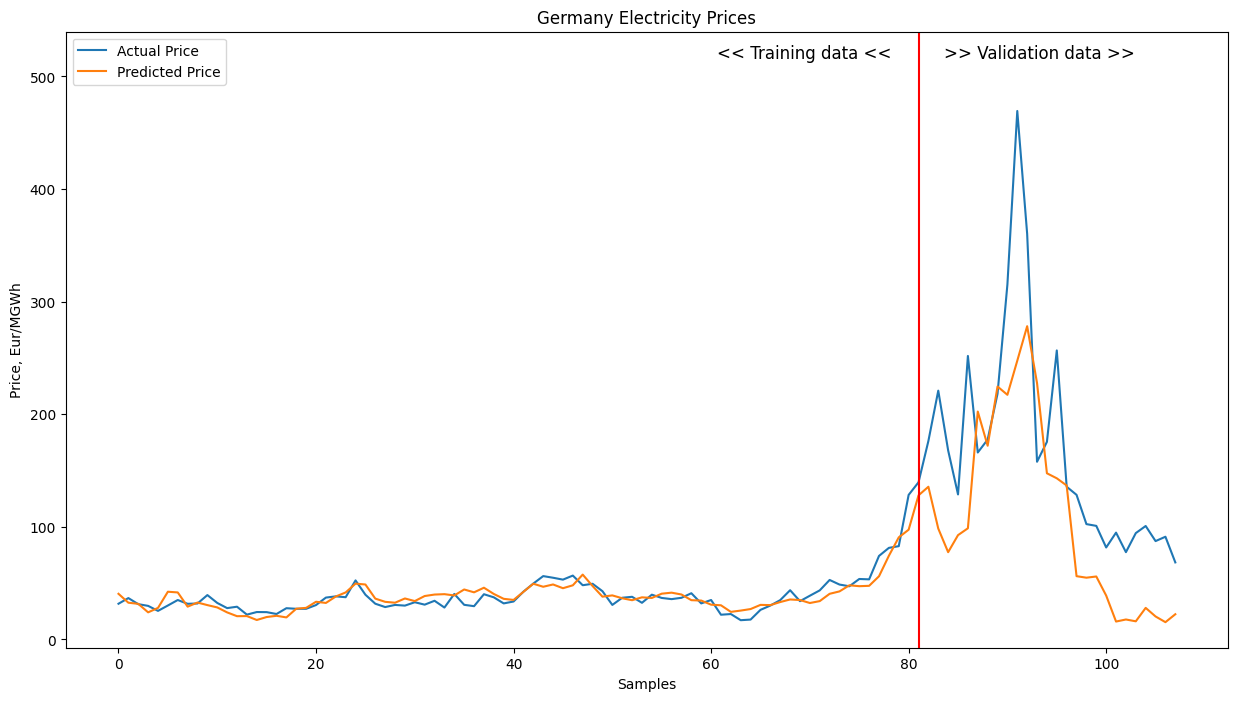

In [56]:
model = LinearRegression()
model.fit(X_train, y_train)

error.append(metrics(X_train, X_test, y_train, y_test, model, country))

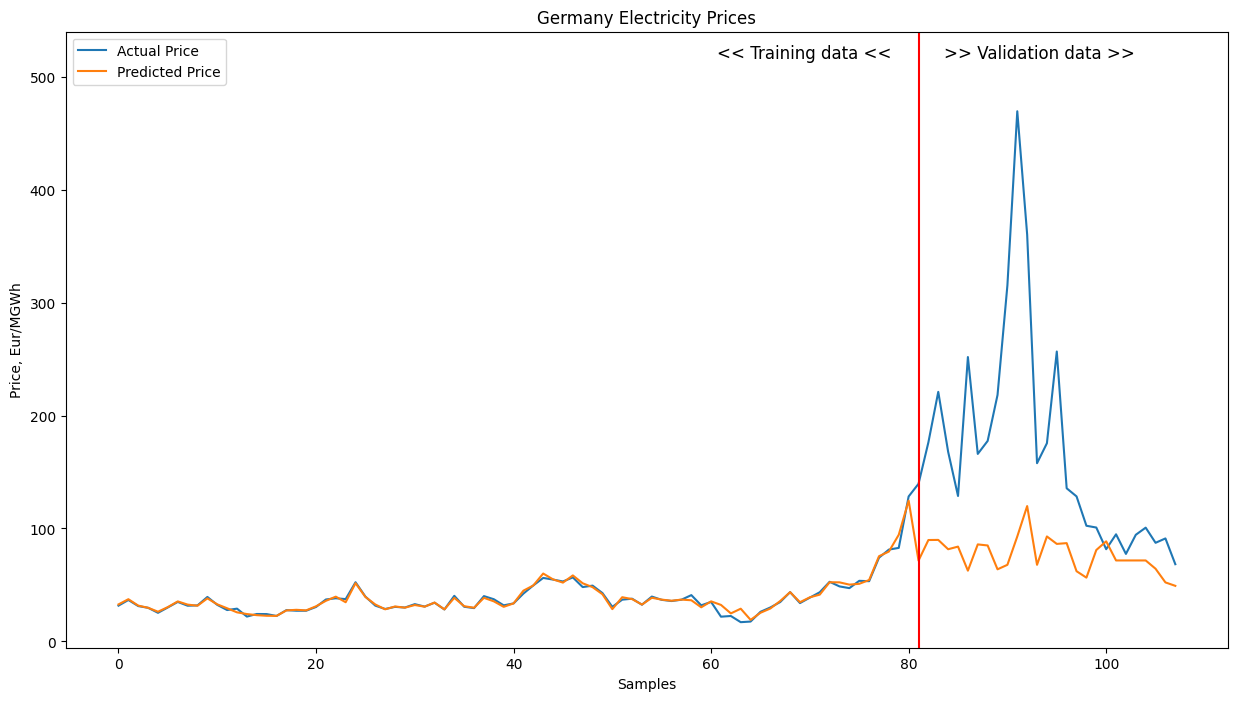

In [57]:
model = GradientBoostingRegressor(
    learning_rate=0.5,
    n_estimators=15,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=1,
    subsample=0.5,
    max_features='sqrt'
)
model.fit(X_train, y_train)

error.append(metrics(X_train, X_test, y_train, y_test, model, country))

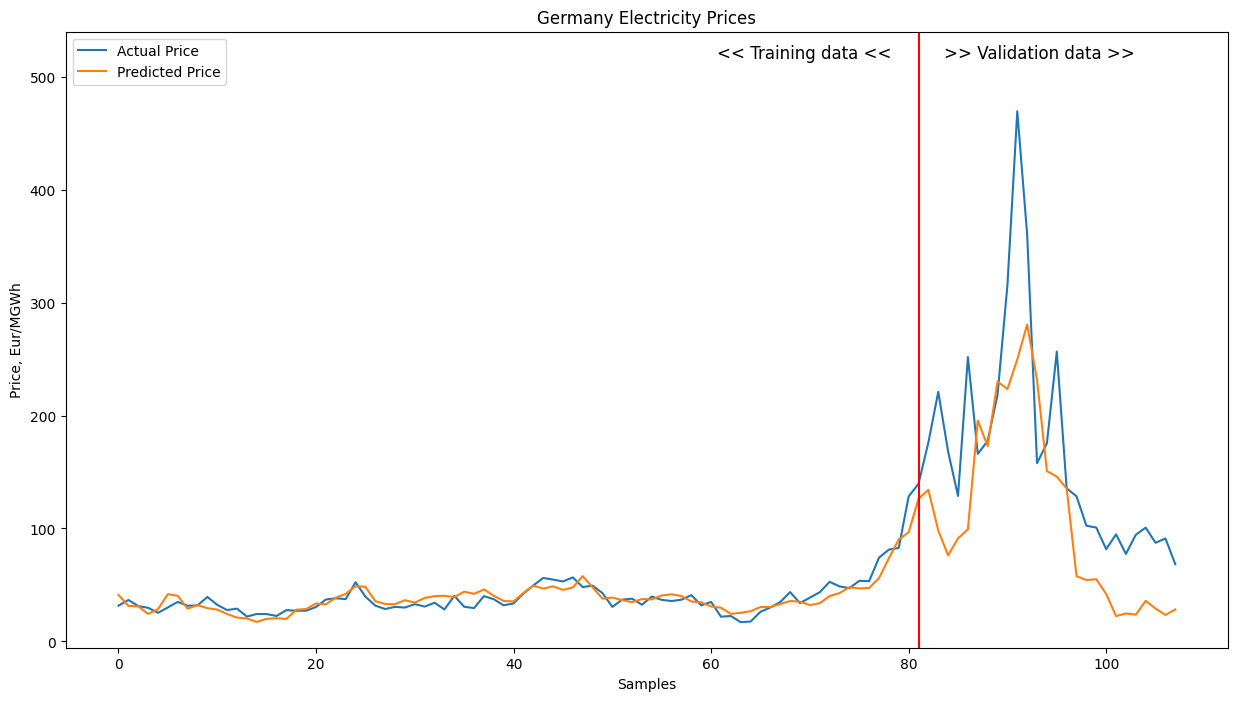

In [58]:
model = Ridge(alpha=0.15)
model.fit(X_train, y_train)

error.append(metrics(X_train, X_test, y_train, y_test, model, country))

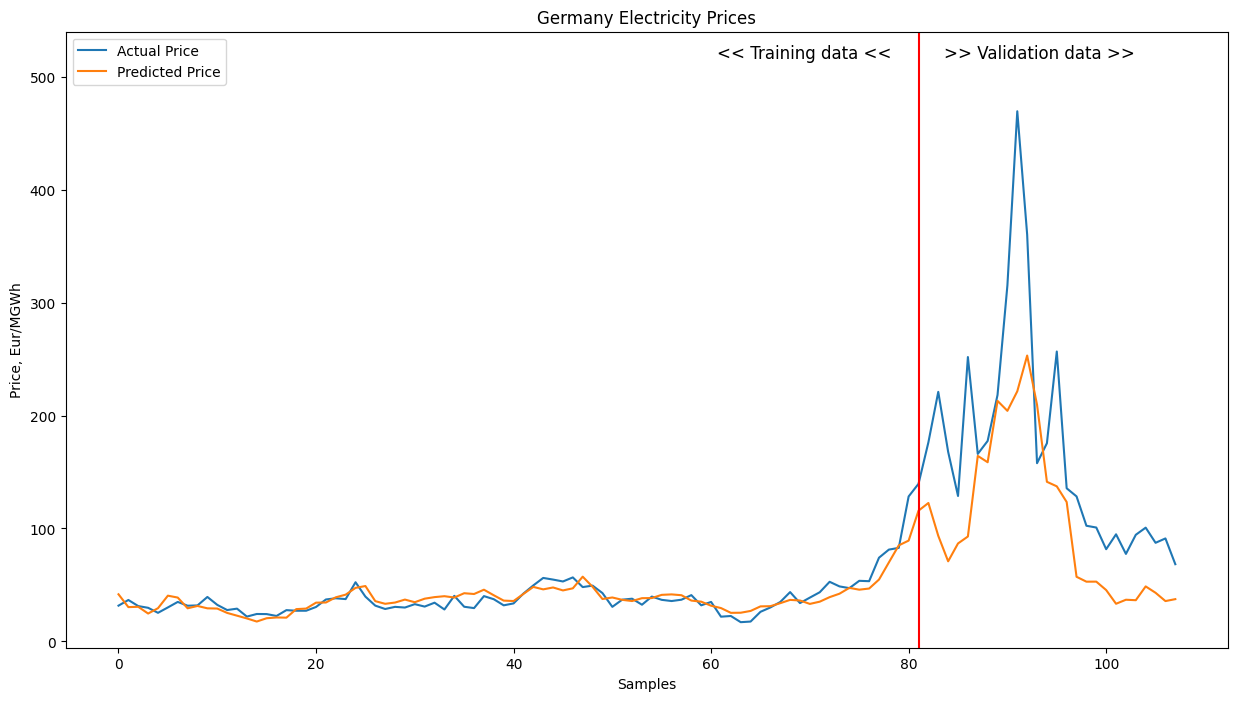

In [59]:
base_model = LinearRegression()
model = BaggingRegressor(estimator=base_model, n_estimators = 20, max_samples = 0.9, max_features = 0.9)

model.fit(X_train, y_train)

error.append(metrics(X_train, X_test, y_train, y_test, model, country))

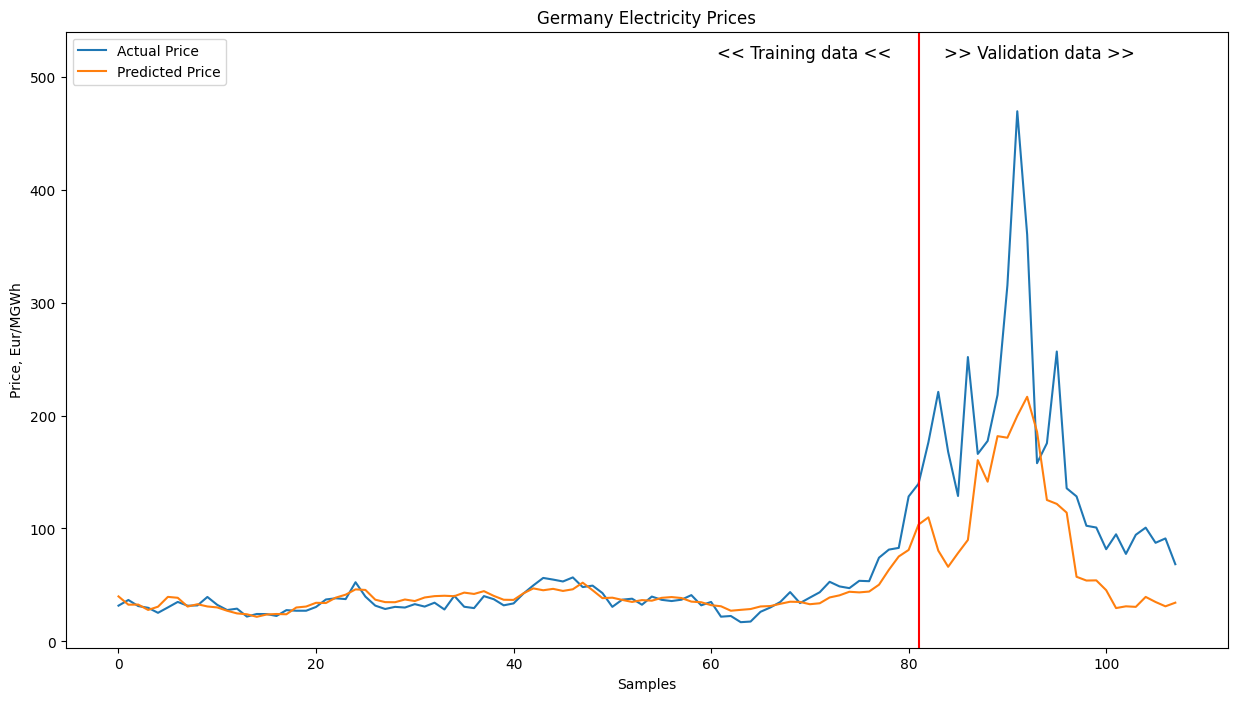

In [60]:
lr = LinearRegression()
ridge = Ridge(alpha=0.5)
lasso = Lasso(alpha=0.5)

model = VotingRegressor(estimators=[
    ('lr', lr),
    ('ridge', ridge),
    ('lasso', lasso)
])

model.fit(X_train, y_train)

error.append(metrics(X_train, X_test, y_train, y_test, model, country))

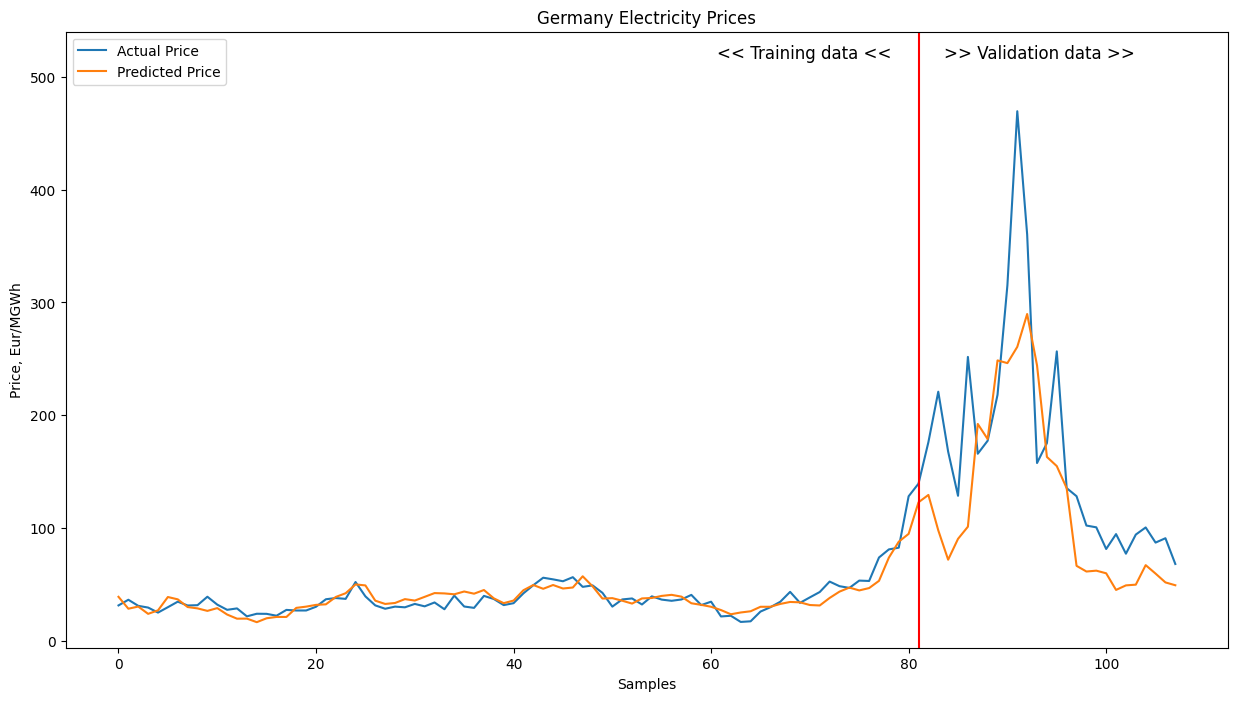

In [61]:
base_model = Ridge(alpha = 0.55)
model = AdaBoostRegressor(estimator=base_model, n_estimators=20)

model.fit(X_train, y_train)

error.append(metrics(X_train, X_test, y_train, y_test, model, country))

In [166]:
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)
# mixed_precision.set_global_policy('float32')

features = X_train.shape[1]


l1_l2_regularization = l1_l2(l1=0.05, l2=0.05)
model = Sequential([
    layers.Dense(32, activation = 'leaky_relu', input_shape = (features,), kernel_regularizer=l1_l2_regularization),
    layers.Dense(32, activation = 'leaky_relu', kernel_regularizer=l1_l2_regularization),
    layers.Dense(32, activation = 'leaky_relu', kernel_regularizer=l1_l2_regularization),
    layers.Dense(32, activation = 'leaky_relu', kernel_regularizer=l1_l2_regularization),
    layers.Dense(32, activation = 'leaky_relu', kernel_regularizer=l1_l2_regularization),
    layers.Dense(32, activation = 'leaky_relu', kernel_regularizer=l1_l2_regularization),
    layers.Dense(32, activation = 'leaky_relu', kernel_regularizer=l1_l2_regularization),
    layers.Dense(16, activation = 'leaky_relu', kernel_regularizer=l1_l2_regularization),
    layers.Dense(1)
])

Adam = tf.keras.optimizers.Adam(
    learning_rate=0.01
)

model.compile(
    optimizer=Adam,
    loss='mean_squared_error',
    metrics=['mse']
)

In [167]:
early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=250,
        min_delta=0.001,
        restore_best_weights=True 
    )
model.fit(X_train, y_train, epochs=1500, batch_size = 45, validation_data=(X_test,y_test), callbacks=[early_stopping])

Epoch 1/1500
2/2 [==============================] - 1s 147ms/step - loss: 98.9073 - mse: 32.3179 - val_loss: 82.3136 - val_mse: 19.2390
Epoch 2/1500
2/2 [==============================] - 0s 23ms/step - loss: 74.8099 - mse: 12.4180 - val_loss: 581.3046 - val_mse: 521.6490
Epoch 3/1500
2/2 [==============================] - 0s 23ms/step - loss: 62.3511 - mse: 3.5610 - val_loss: 186.1954 - val_mse: 130.4013
Epoch 4/1500
2/2 [==============================] - 0s 29ms/step - loss: 58.0386 - mse: 3.0505 - val_loss: 188.0364 - val_mse: 135.7945
Epoch 5/1500
2/2 [==============================] - 0s 32ms/step - loss: 53.2915 - mse: 1.7974 - val_loss: 310.3853 - val_mse: 261.5116
Epoch 6/1500
2/2 [==============================] - 0s 24ms/step - loss: 49.8919 - mse: 1.7819 - val_loss: 190.6281 - val_mse: 145.2144
Epoch 7/1500
2/2 [==============================] - 0s 26ms/step - loss: 45.7816 - mse: 1.1374 - val_loss: 81.5293 - val_mse: 39.5173
Epoch 8/1500
2/2 [==============================]

Aggregated Loss: [69.47968139648438, 42.70135269165039, 28.808940505981447, 20.552108001708984, 15.334983444213867, 11.78846092224121, 9.30363712310791, 7.585012912750244, 6.381163597106934, 5.520938968658447, 4.91593828201294, 4.468653583526612, 4.119025993347168, 3.859352779388428, 3.636217498779297, 3.448733854293823, 3.2783456802368165, 3.1373133182525637, 3.0047388076782227, 2.8946901321411134, 2.7951306819915773, 2.712484359741211, 2.624651622772217, 2.553043842315674, 2.485947513580322, 2.420512628555298, 2.360808277130127, 2.302738904953003, 2.2505300998687745, 2.210863161087036, 2.162507724761963, 2.1250070571899413, 2.085597801208496, 2.0523765087127686, 2.0276365280151367, 1.9938354730606078, 1.9586472511291504, 1.9363168239593507, 1.9131513595581056, 1.8883714914321899, 1.864388680458069, 1.852433681488037, 1.8311678647994996, 1.80142240524292, 1.7848905801773072, 1.7650480270385742, 1.7509871959686278, 1.73423912525177, 1.7107152223587037, 1.6970781087875366, 1.67610371112

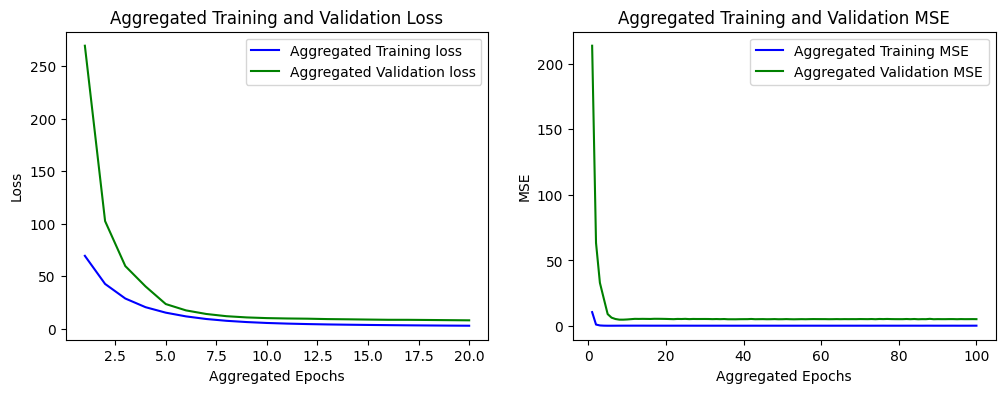

In [168]:
training_process(model)

1/1 [==============================] - 0s 48ms/step
Validation - 4.8059320008741
3/3 [==============================] - 0s 2ms/step
Training - 0.3160237700758935
4/4 [==============================] - 0s 1ms/step
All - 1.4385852160559633


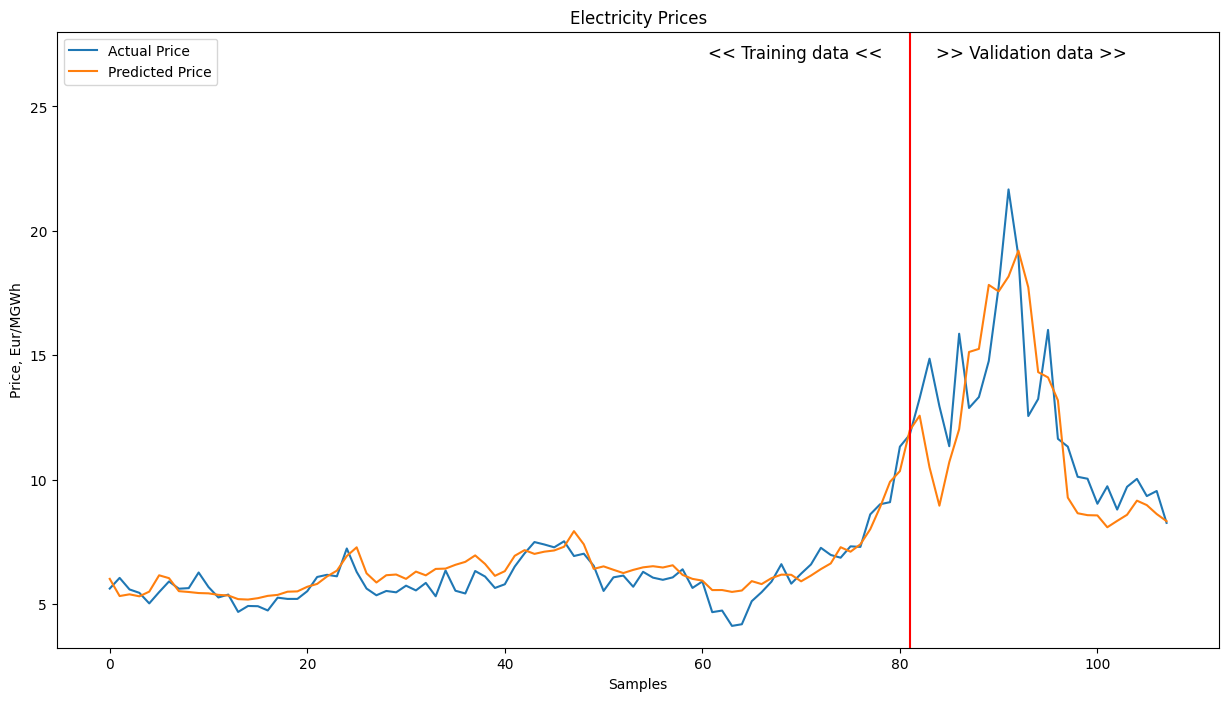

In [169]:
error.append(metrics(X_train, X_test, y_train, y_test, model))

In [170]:
names = ['Linear Regression', 'Gradient Boosting Regressor', 'Ridge',
         'Linear Regression + Bagging', 'Voting (Linear + Ridge + Lasso)',
         'Ada Boost + Ridge', 'Deep Neural Network']

validation = [x for x, _ in error]
training = [y for _, y in error]

n = len(error)

bar_width = 0.45

r = np.arange(n)

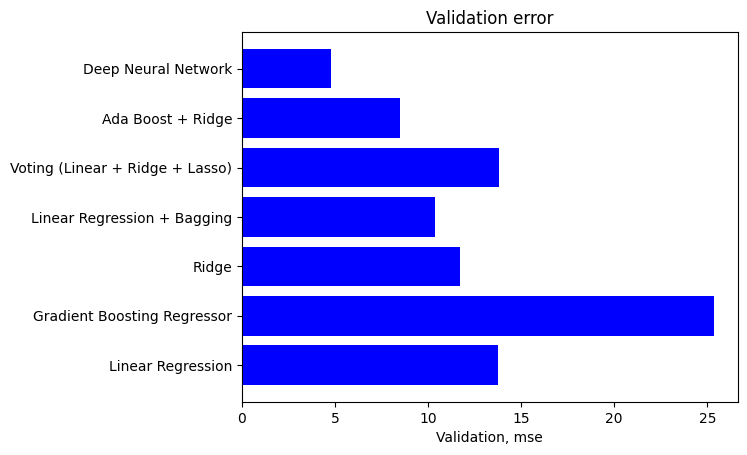

In [171]:
# f, (b1, b2) = plt.subplots(2,1, figsize=(6, 12))
plt.barh(r, validation, color='b')
plt.yticks(ticks = range(len(names)), labels = names, ha='right')
plt.xlabel('Validation, mse')
plt.title('Validation error')
plt.show()

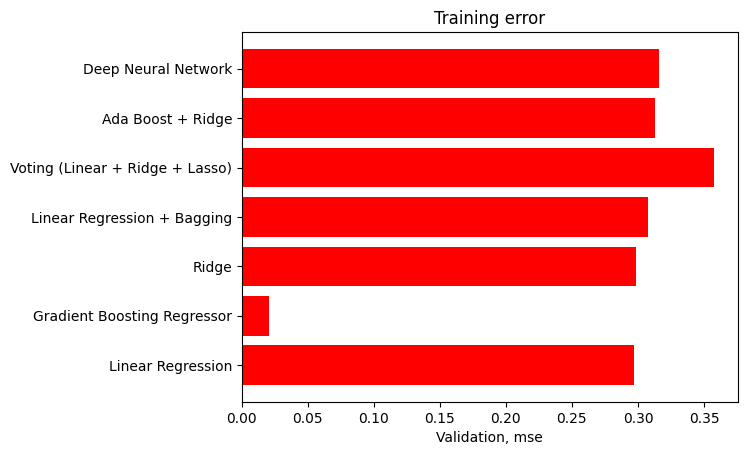

In [172]:
plt.barh(r, training, color='r')
plt.xlabel('Validation, mse')
plt.yticks(ticks = range(len(names)), labels = names, ha='right')
plt.title('Training error')
plt.show()

We can see that the best model is a Deep Neural Network. Even though it does not have the lowest training error but it has the lowest validation data error,<br>
which means it is more capable to work with unseen data. Worst model is the Gradient Boosting Regressor. It has the worst validation results, looking at the visual graph of predicted values<br>
we can see that it is not capable to even hold the trend.

I will pick Deep Neural Network and train each country on it individually. So, each country will have their own model.

In [173]:
dnn_models = {}
for i in training_data.keys():
    X_train, X_test, y_train, y_test = train_test_split(training_data[i][0], training_data[i][1], test_size=0.25, shuffle=False)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    features = X_train.shape[1]


    l1_l2_regularization = l1_l2(l1=0.05, l2=0.05)
    model = Sequential([
        layers.Dense(32, activation = 'leaky_relu', input_shape = (features,), kernel_regularizer=l1_l2_regularization),
        layers.Dense(32, activation = 'leaky_relu', kernel_regularizer=l1_l2_regularization),
        layers.Dense(32, activation = 'leaky_relu', kernel_regularizer=l1_l2_regularization),
        layers.Dense(32, activation = 'leaky_relu', kernel_regularizer=l1_l2_regularization),
        layers.Dense(32, activation = 'leaky_relu', kernel_regularizer=l1_l2_regularization),
        layers.Dense(32, activation = 'leaky_relu', kernel_regularizer=l1_l2_regularization),
        layers.Dense(32, activation = 'leaky_relu', kernel_regularizer=l1_l2_regularization),
        layers.Dense(16, activation = 'leaky_relu', kernel_regularizer=l1_l2_regularization),
        layers.Dense(1)
    ])

    Adam = tf.keras.optimizers.Adam(
        learning_rate=0.01
    )

    model.compile(
        optimizer=Adam,
        loss='mean_squared_error',
        metrics=['mse']
    )

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=250,
        min_delta=0.001,
        restore_best_weights=True 
    )
    model.fit(X_train, y_train, epochs=1500, batch_size = 45, validation_data=(X_test,y_test), callbacks=[early_stopping])

    dnn_models[i] = model

Epoch 1/1500
2/2 [==============================] - 1s 146ms/step - loss: 109.1848 - mse: 43.8418 - val_loss: 213.6138 - val_mse: 153.8713
Epoch 2/1500
2/2 [==============================] - 0s 38ms/step - loss: 93.1157 - mse: 34.6405 - val_loss: 134.5970 - val_mse: 79.9488
Epoch 3/1500
2/2 [==============================] - 0s 39ms/step - loss: 67.0393 - mse: 13.1883 - val_loss: 113.8914 - val_mse: 62.8880
Epoch 4/1500
2/2 [==============================] - 0s 27ms/step - loss: 60.1531 - mse: 10.0221 - val_loss: 64.2978 - val_mse: 17.2042
Epoch 5/1500
2/2 [==============================] - 0s 28ms/step - loss: 48.5166 - mse: 2.2479 - val_loss: 57.8557 - val_mse: 14.3938
Epoch 6/1500
2/2 [==============================] - 0s 33ms/step - loss: 47.5513 - mse: 4.8292 - val_loss: 56.8070 - val_mse: 16.5752
Epoch 7/1500
2/2 [==============================] - 0s 24ms/step - loss: 43.2970 - mse: 3.7262 - val_loss: 83.4258 - val_mse: 46.1068
Epoch 8/1500
2/2 [==============================] - 

In [179]:
for i in dnn_models.keys():
    dnn_models[i].save(f'models/{i}_model.h5')

4/4 [==============================] - 0s 2ms/step


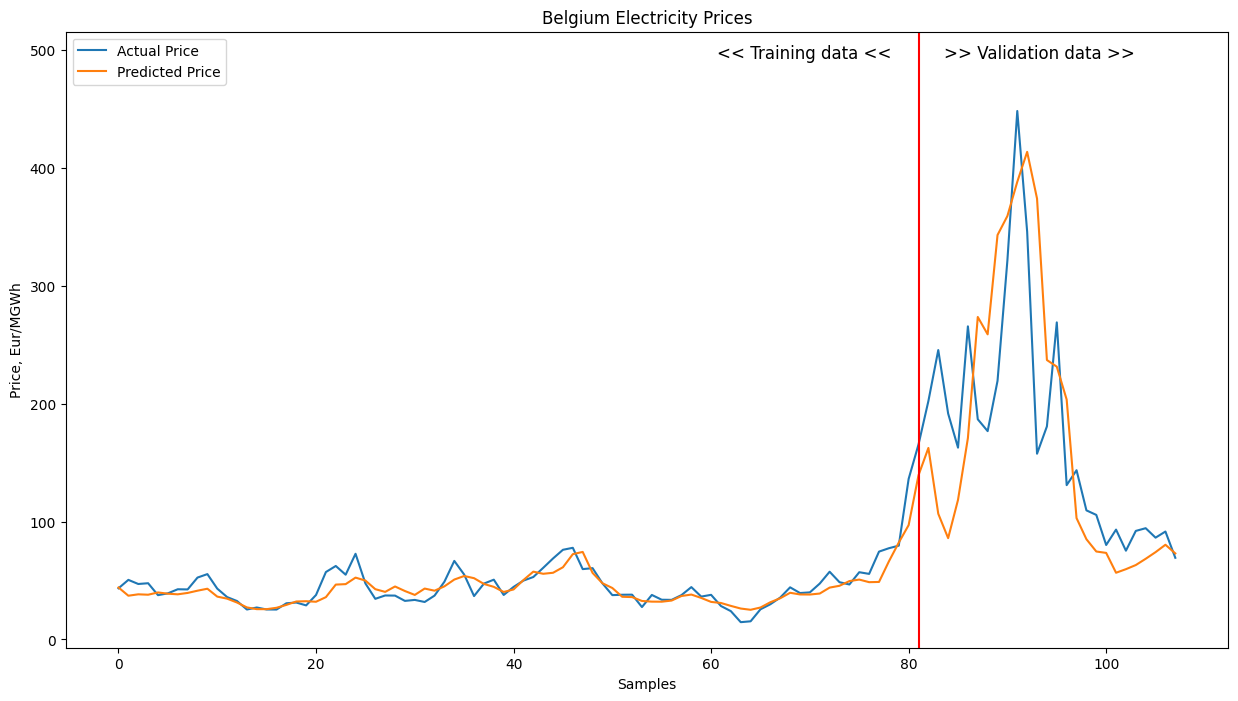

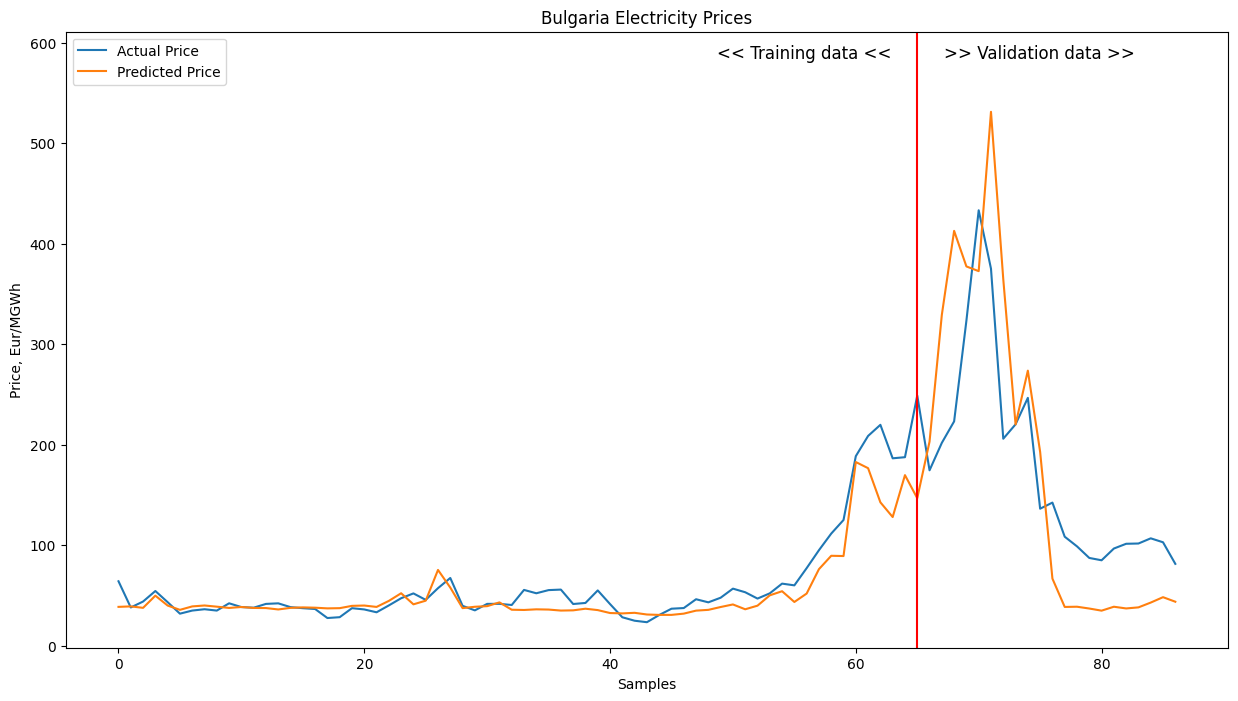

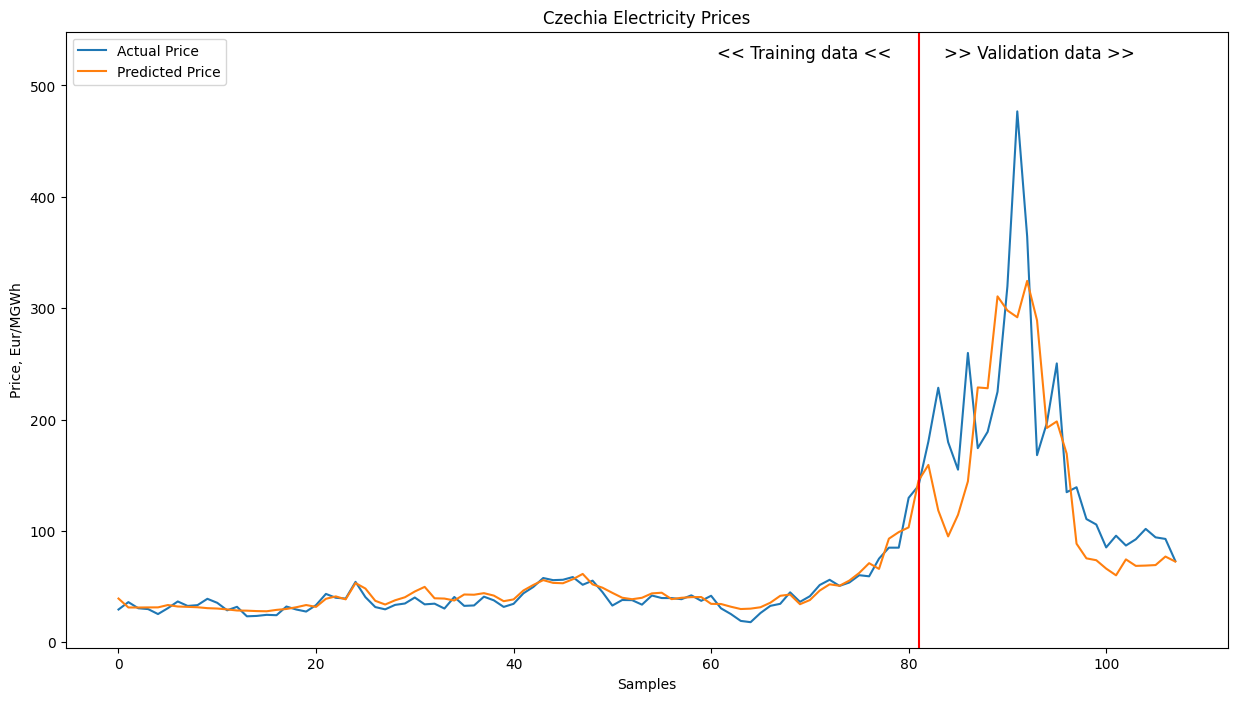

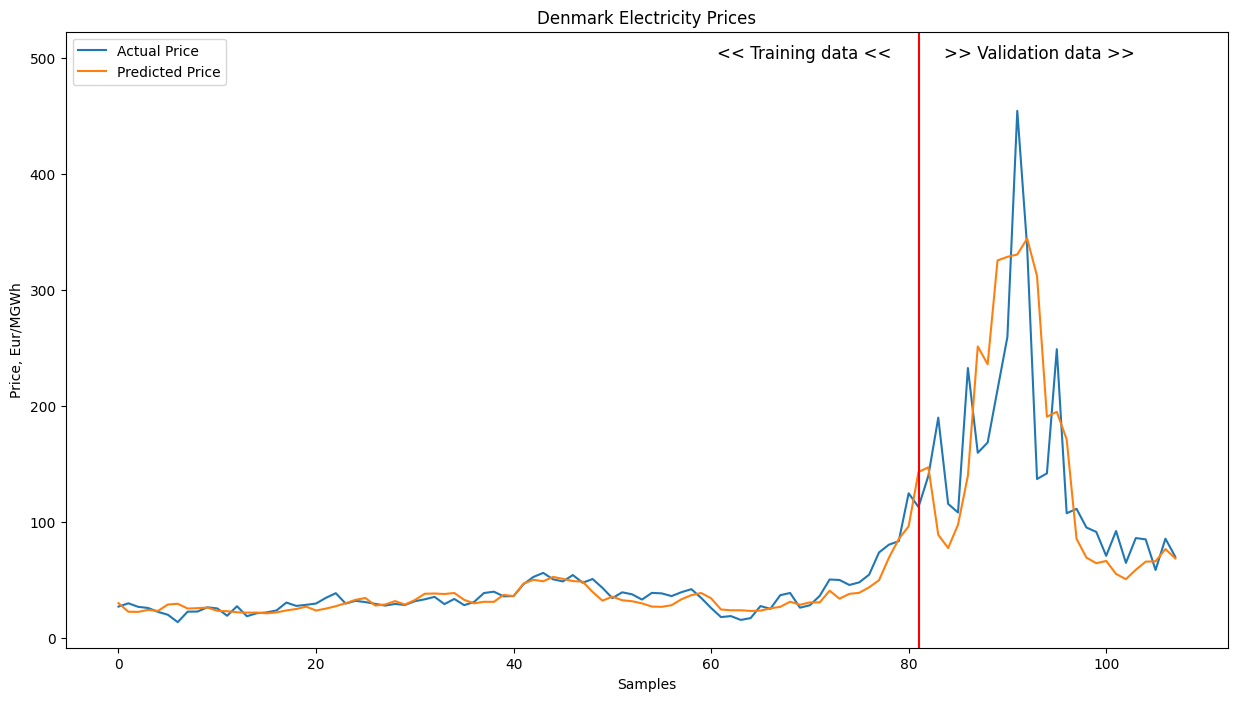

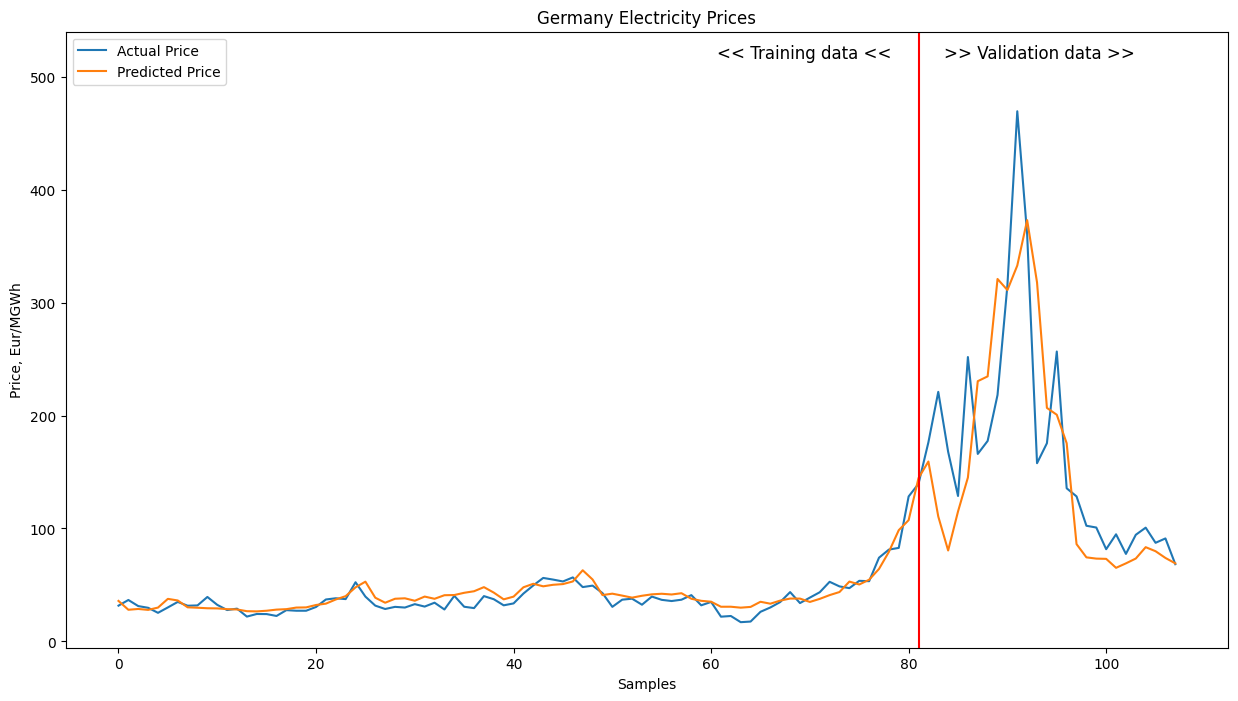

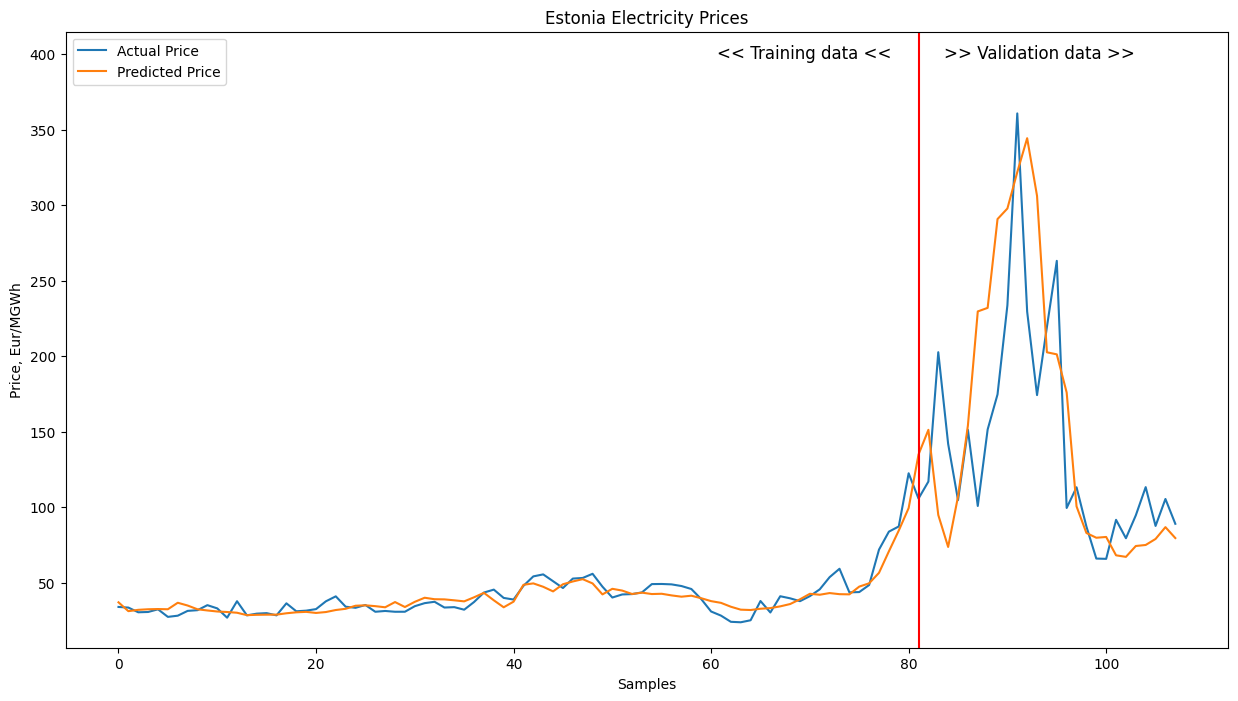

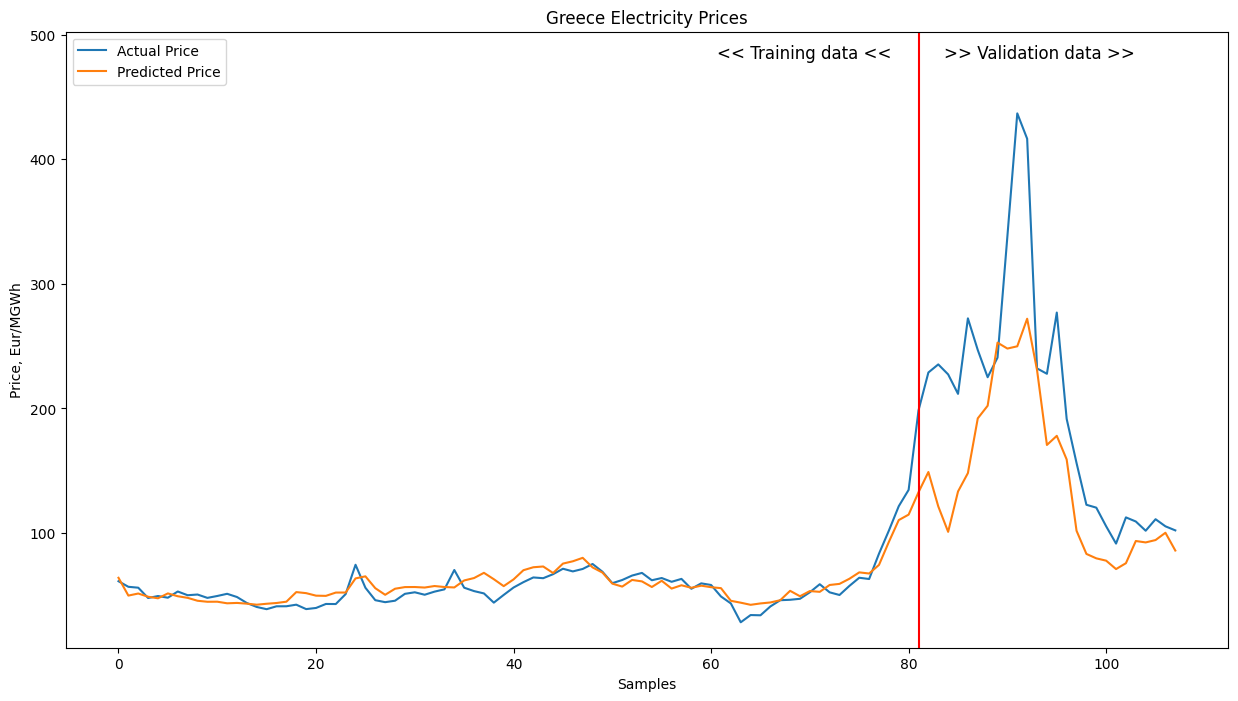

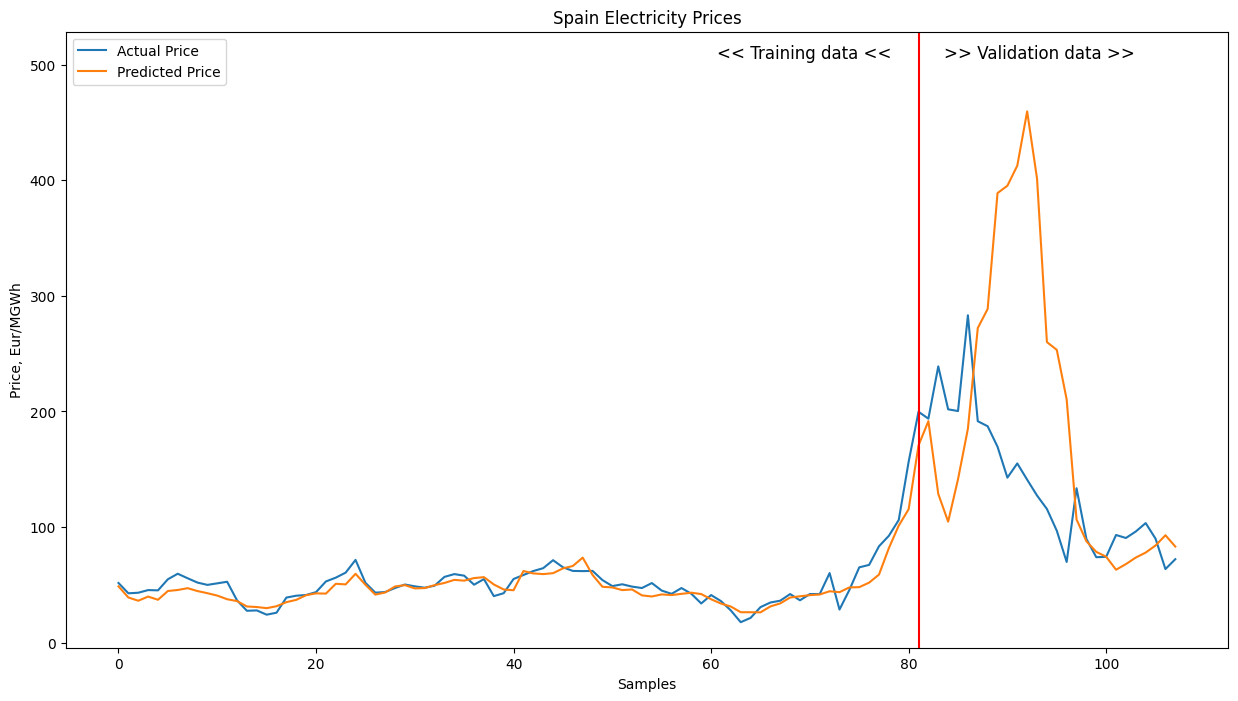

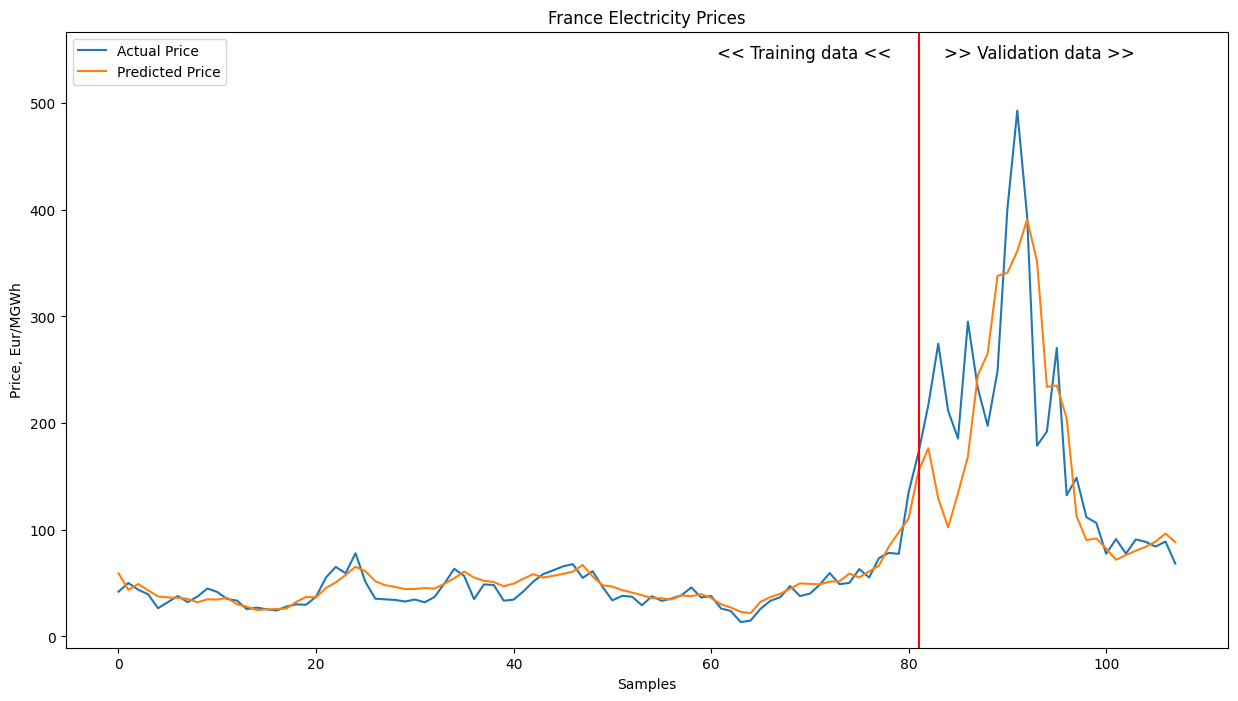

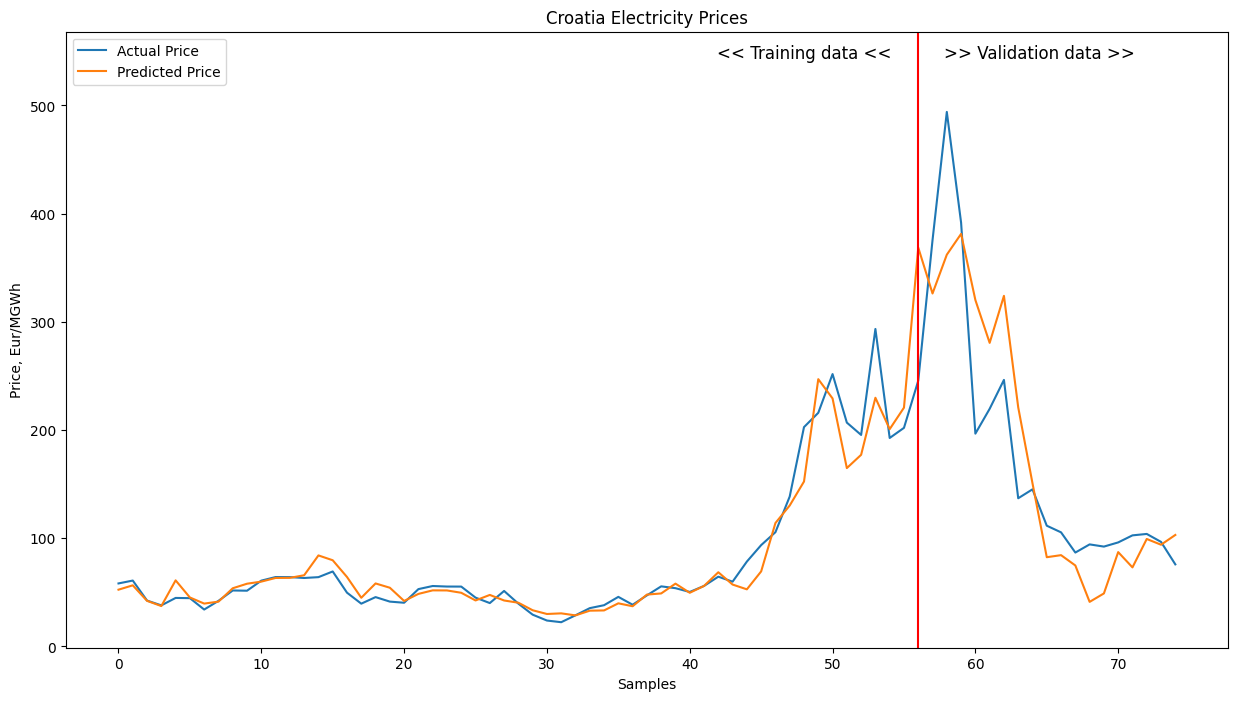

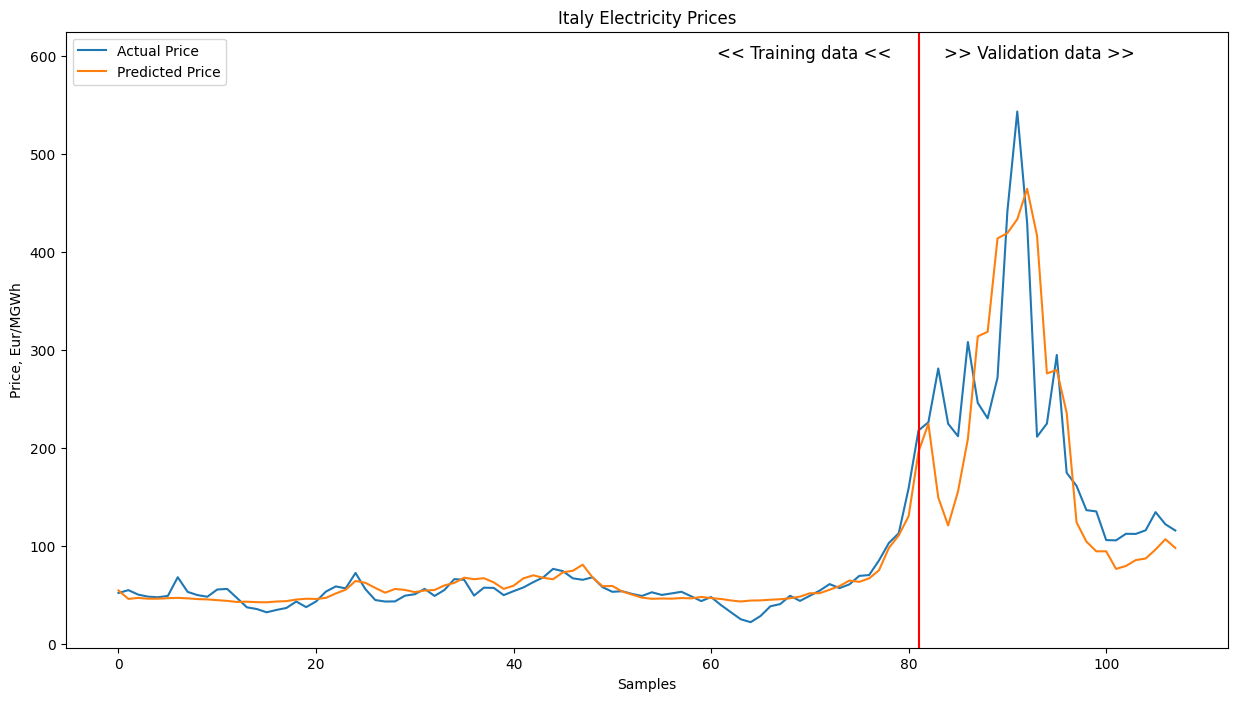

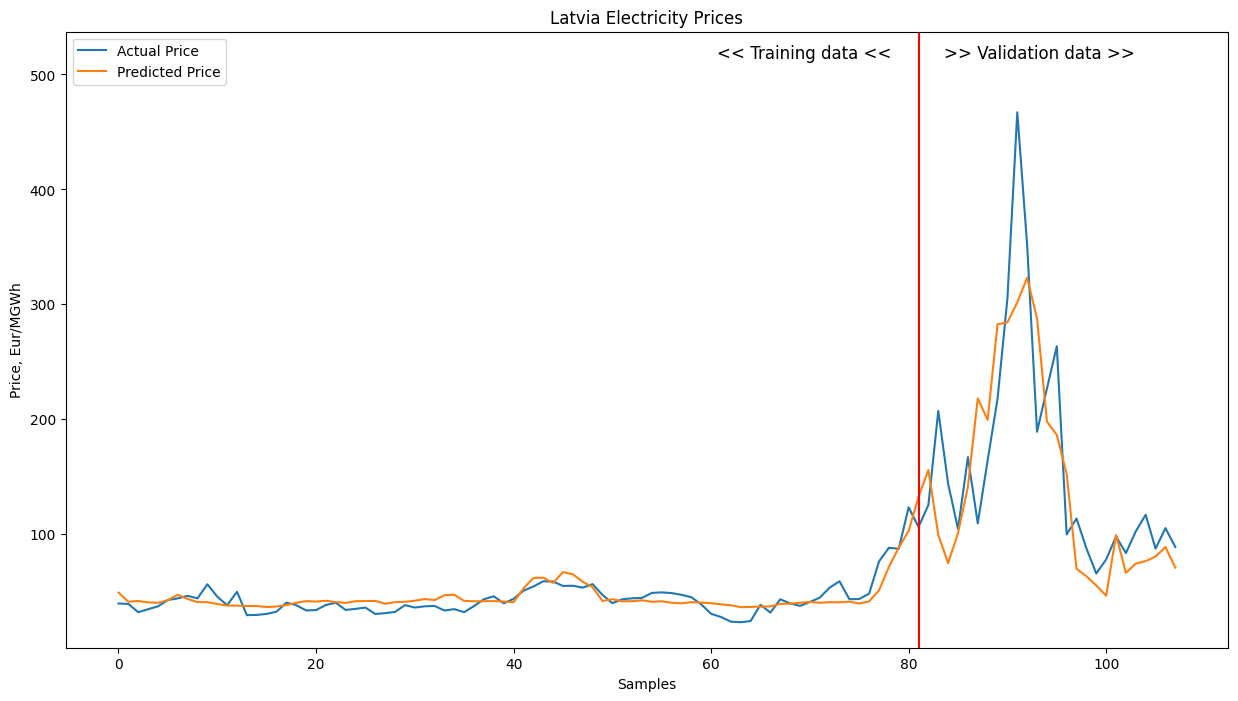

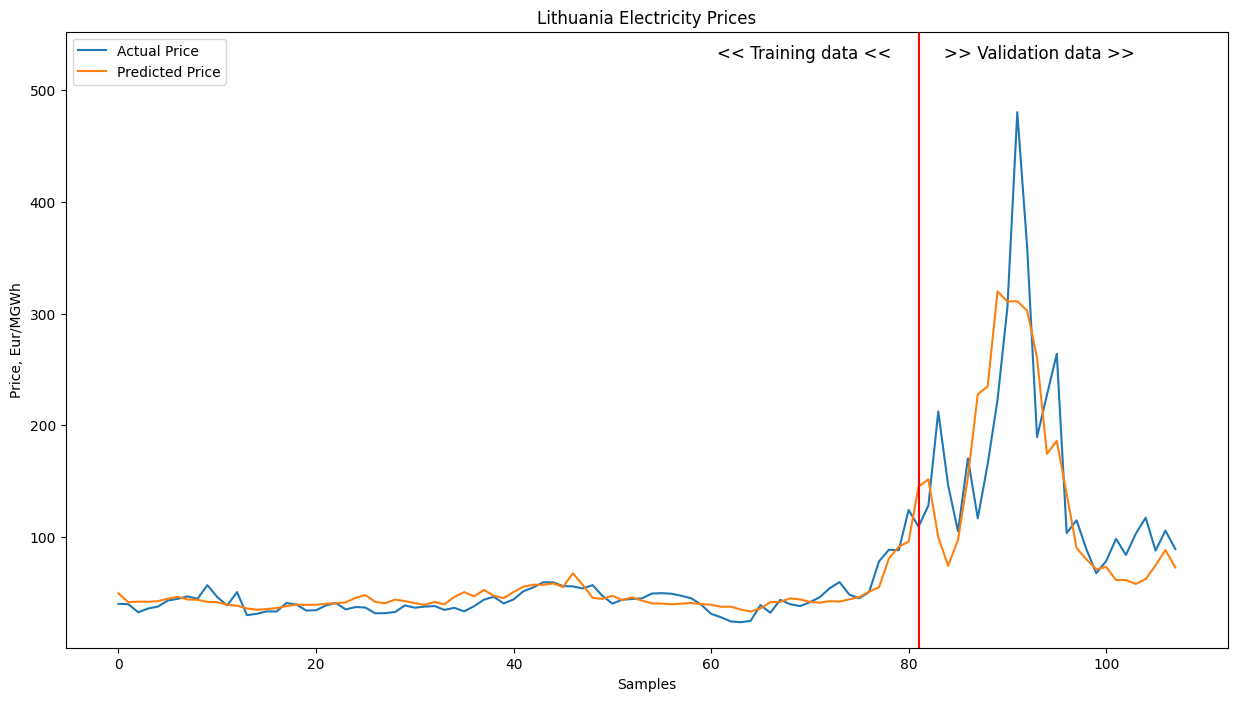

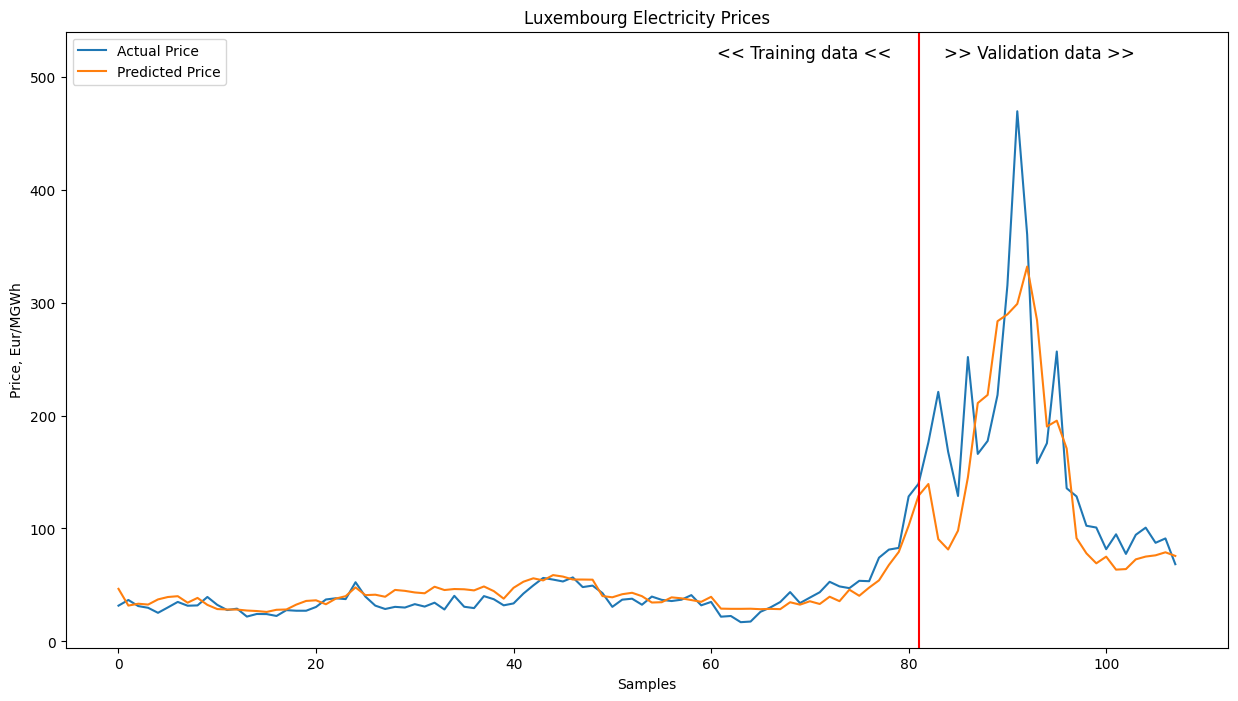

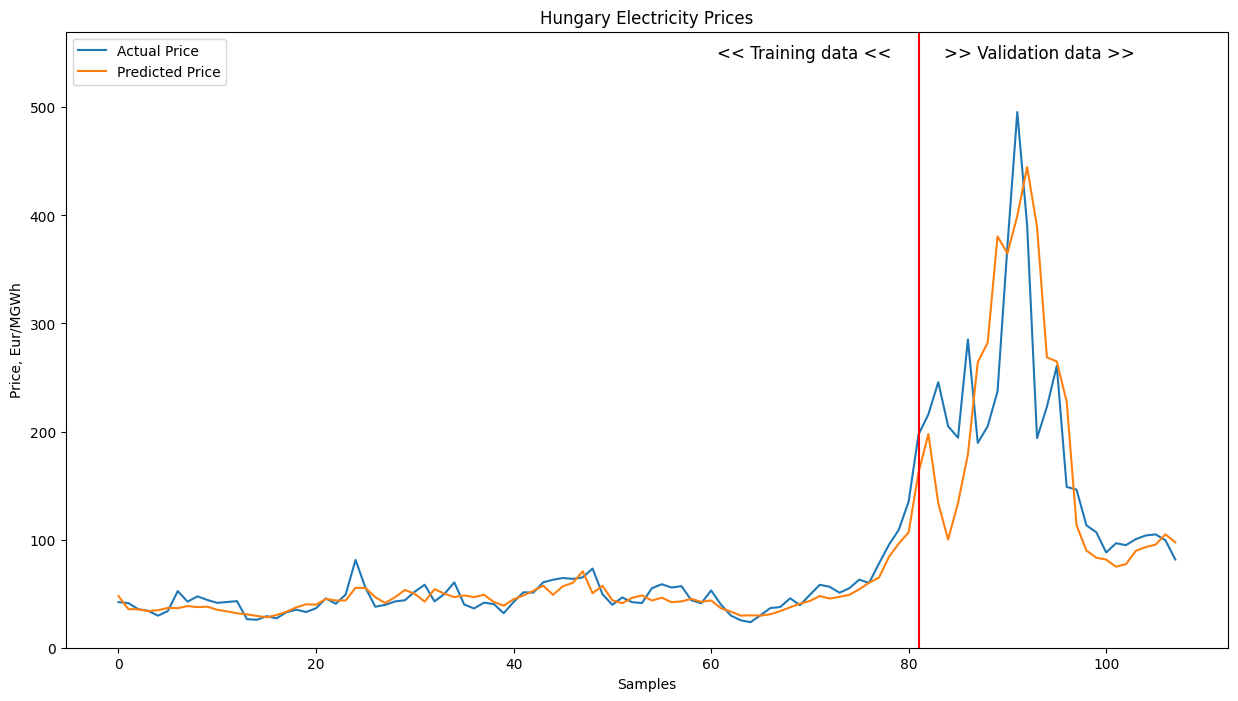

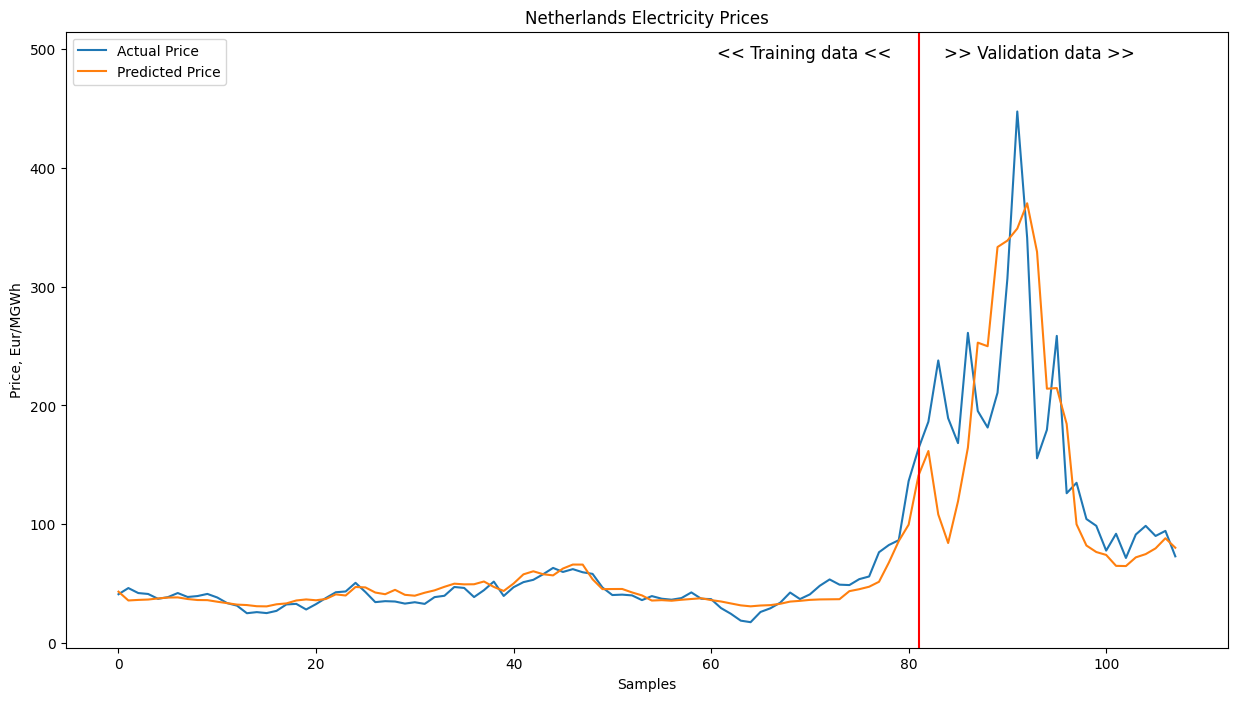

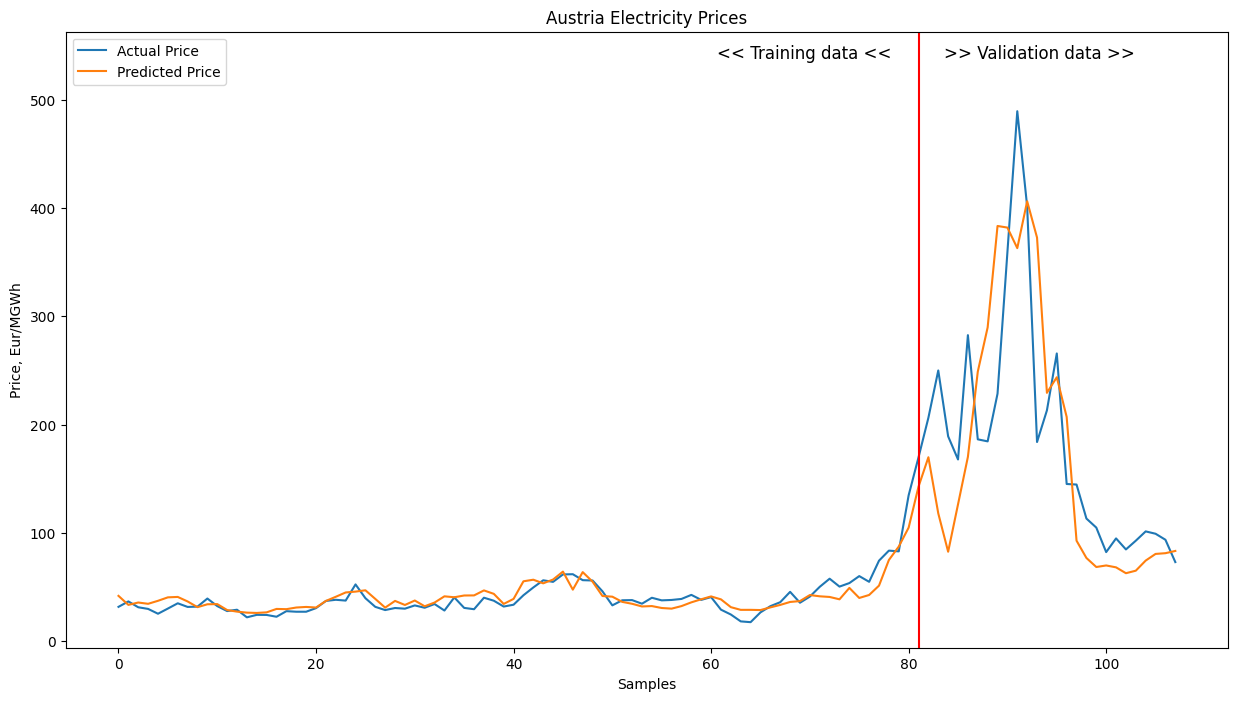

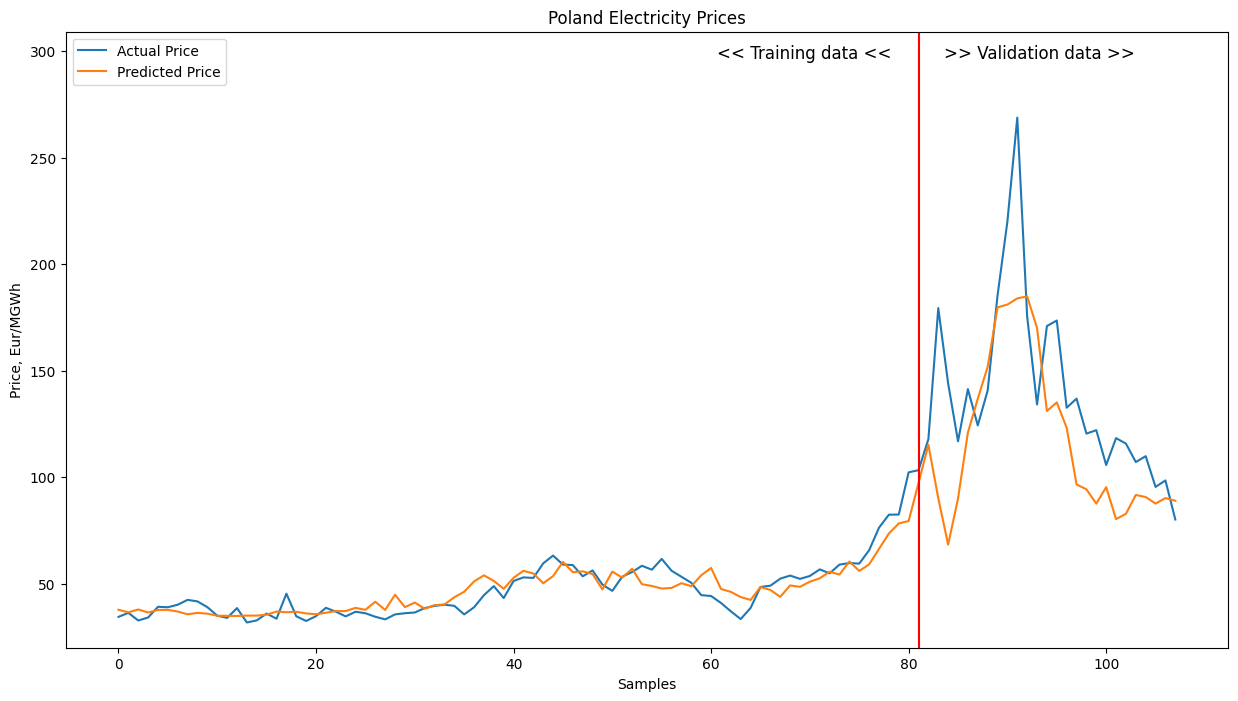

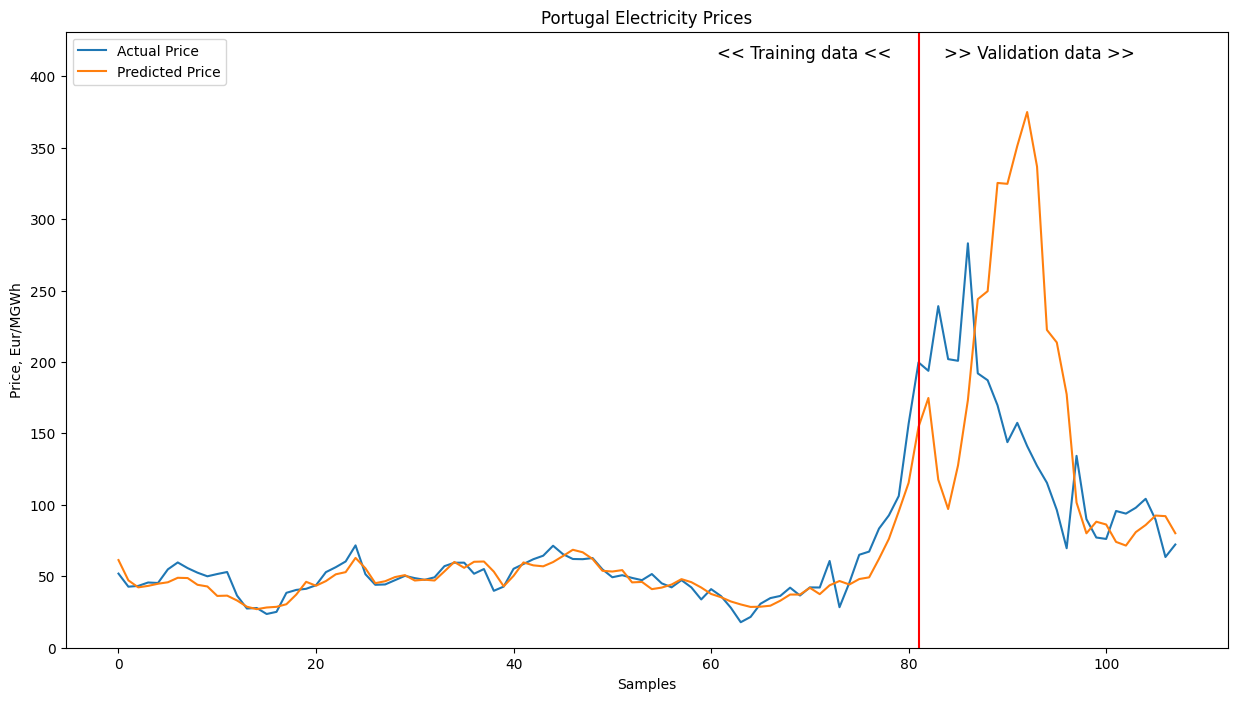

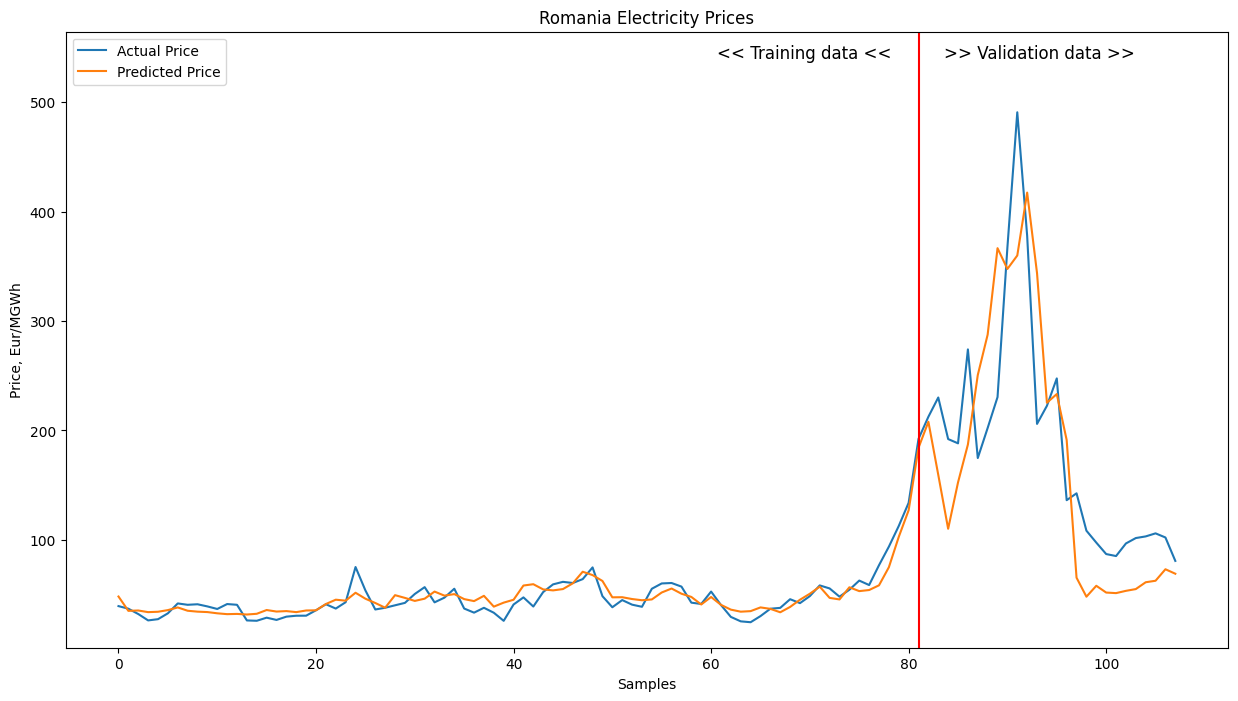

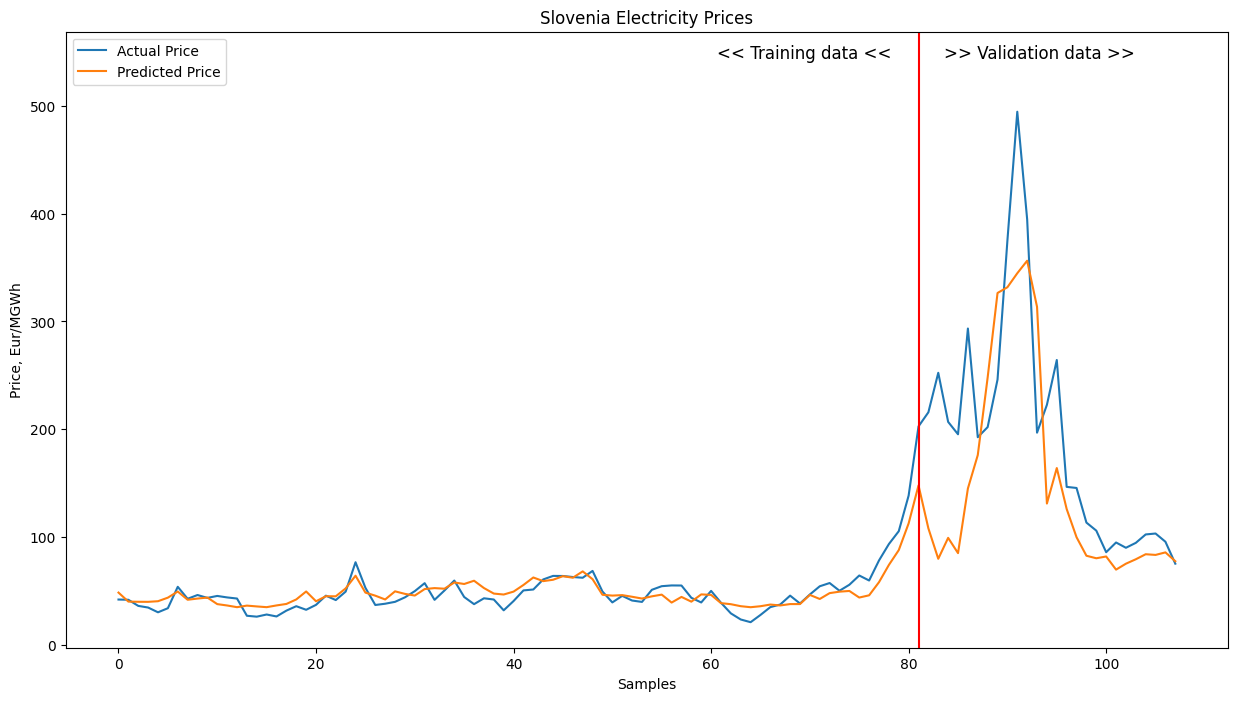

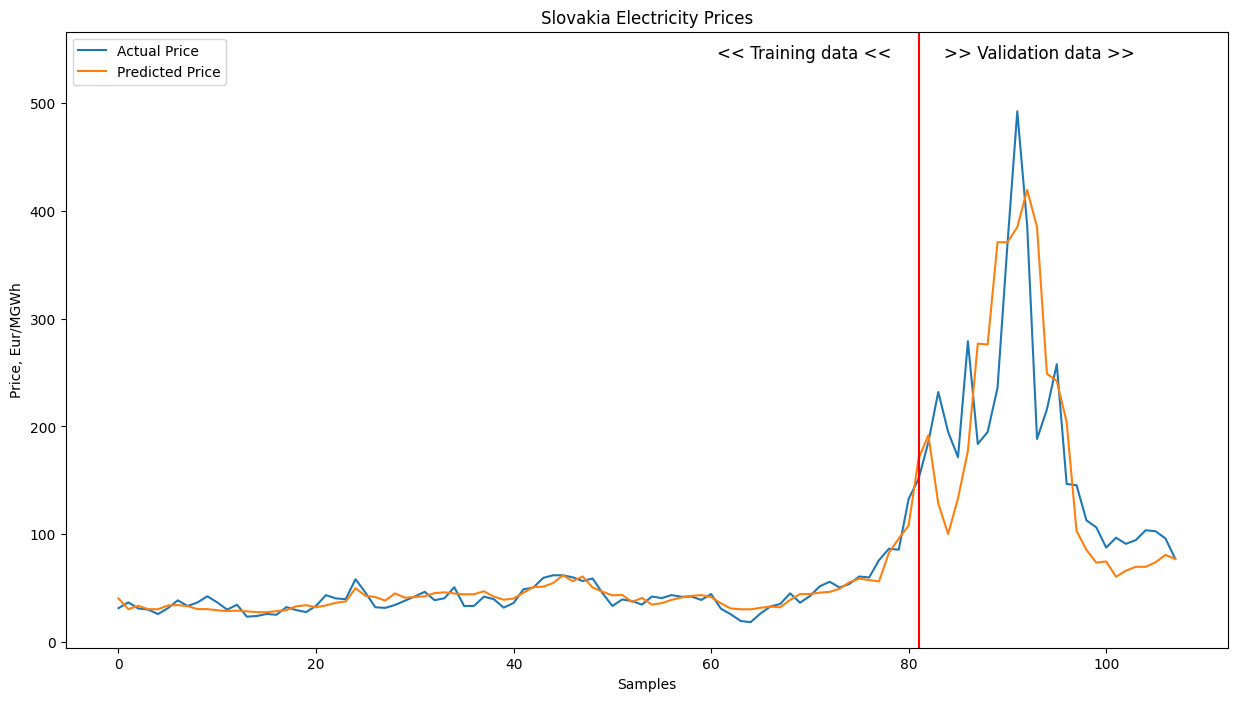

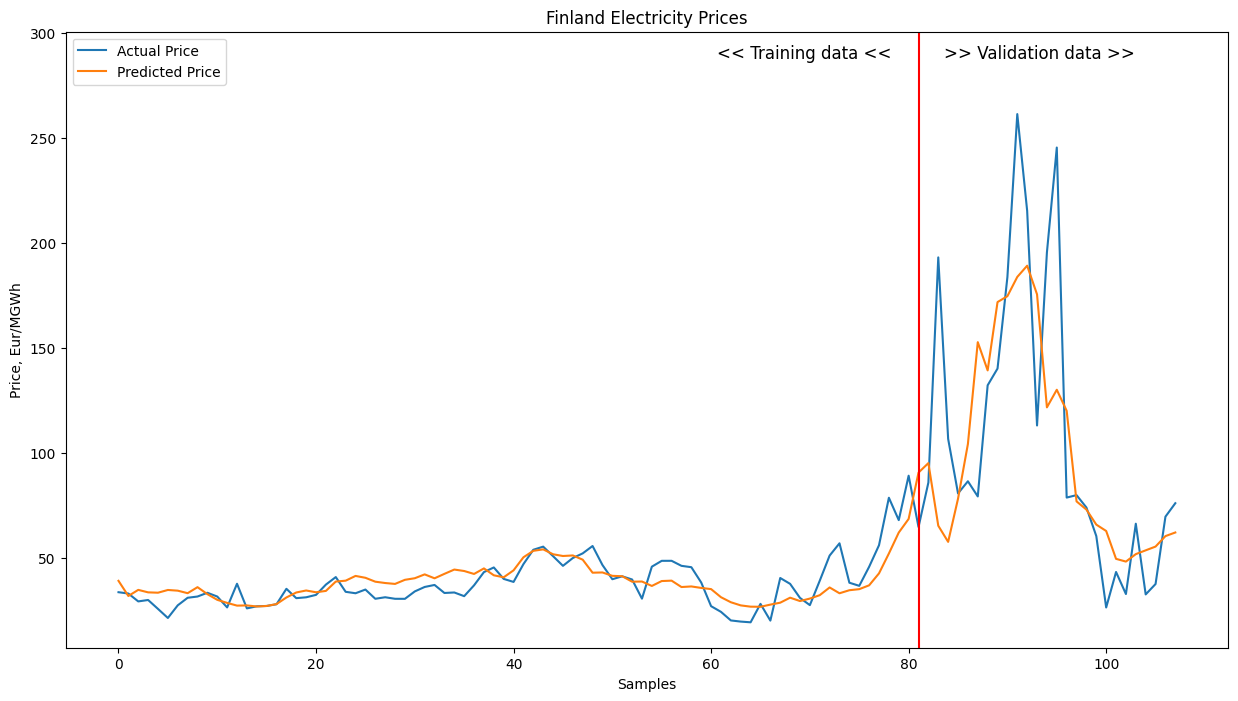

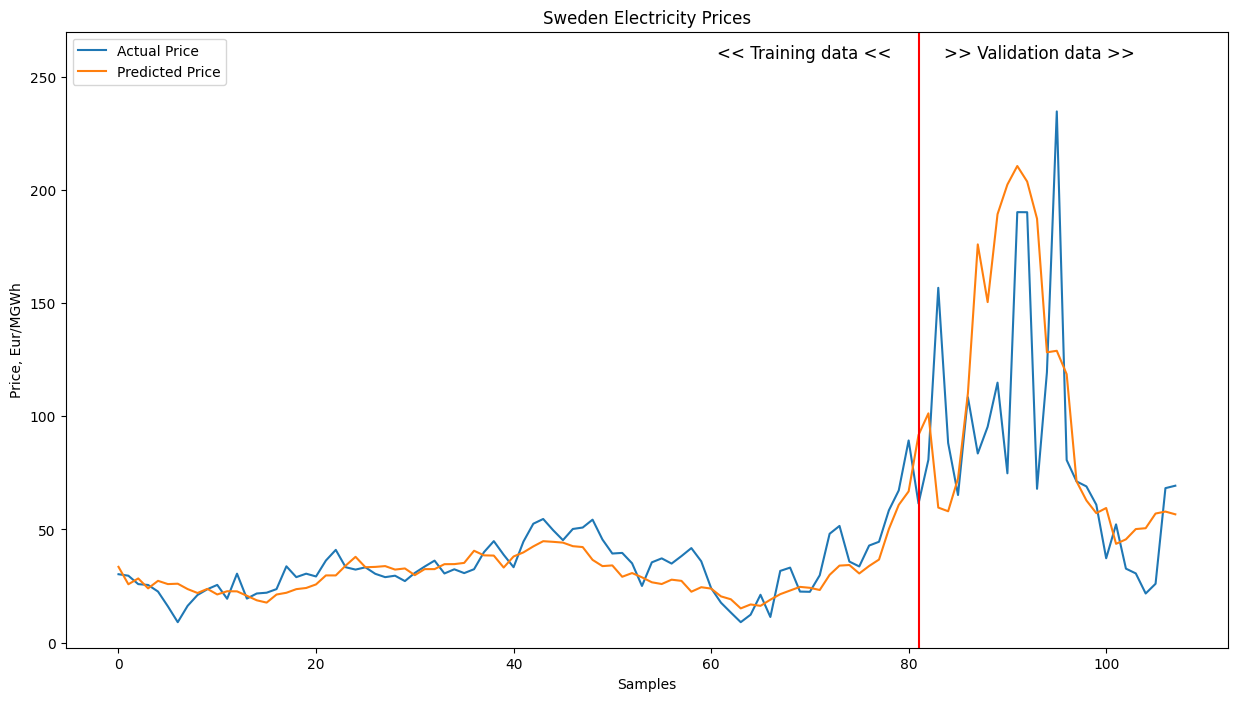

In [216]:
for i in dnn_models.keys():
    X_train, X_test, y_train, y_test = train_test_split(training_data[i][0], training_data[i][1], test_size=0.25, shuffle=False)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    metrics(X_train, X_test, y_train, y_test, dnn_models[i], i)

We can see some countries fit better than the others. It is because each country is unique by its geopolitical situation and how it is affected by certain internal and external factors.<br>
To improve results we could analyse each country individualy and select features that are more suitable for their situation.<br>
Also, we did not apply any optimization techniques to our models and used only MSE to evaluate them. Depending on purpose we might be interested in error variance and confidence level,<br>
or accuracy of ability to tell if price will increase or decrease.